# **Machine Learning using Grammatical Evolution**
### Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Clone GRAPE repository***

In [1]:
import os.path

In [2]:
PATH = '/users/ranyahwigi/desktop/FYP/grape'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /users/ranyahwigi/desktop/FYP/grape/

grape directory already exists
/Users/ranyahwigi/Desktop/FYP/grape


In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [4]:
!pip install deap
!pip install numpy
!pip install -U imbalanced-learn

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math

### ***Preparing Data***

**Loading dataset**

In [5]:
# loading in the dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

**Extracting information on the data**

*Size of dataset*

In [6]:
# number of rows in dataset
number_of_samples = data['PatientID'].count()

**Dropping columns from dataset**

In [7]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [8]:
final_number_of_columns = len(data.columns)

**Train and test split**

In [9]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

Training (X,Y):	 (33625, 104) (33625,)
Test (X,Y):	 (14411, 104) (14411,)


**Check grammar file**

In [49]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|

**Setup grammar**

In [50]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar.bnf")

### ***Fitness Function***

In [10]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
    numerator = (TP+TN)
    denominator = (TP+TN+FP+FN)
    fitness = numerator / denominator

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [52]:
POPULATION_SIZE = 500
MAX_GENERATIONS = 150
P_CROSSOVER = 0.8
P_MUTATION = 0.03
ELITE_SIZE = round(0.02*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 17
MIN_INIT_TREE_DEPTH = 7
MAX_TREE_DEPTH = 27
MAX_WRAPS = 0
CODON_SIZE = 320

**Creating DEAP toolbox**

In [53]:
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

toolbox.register("select", ge.selTournament, tournsize=5)

toolbox.register("mate", ge.crossover_onepoint)

toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [54]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std      	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.509113	0.0295102	0.423732	0.607881	0.419194    	271            	438.212   	2476      	0             	19.8317        
1  	367    	0.499953	0.0280208	0.423732	0.571331	0.572479    	231            	504.29    	1902      	0.0027771     	10.2234        
2  	48     	0.505959	0.0293397	0.402052	0.588372	0.59066     	1052           	367.928   	1542      	0.00290084    	9.41788        
3  	30     	0.506858	0.0311131	0.402052	0.581056	0.59066     	1052           	387.978   	1589      	0.00279188    	9.45453        
4  	22     	0.510074	0.0316247	0.402052	0.596788	0.595934    	372            	374.664   	1552      	0.0028441     	9.61125        
5  	11     	0.509802	0.0317232	0.402052	0.596788	0.595934    	372            	357.172   	1547      	0.0030489     	9.58133        
6  	7      	0.512552	0.0358016	0.360595	0.596788	0.595934    	372            	348.6

62 	0      	0.529876	0.0625686	0.355599	0.643985	0.648324    	227            	423.52    	955       	0.00285006    	7.66484        
63 	3      	0.530595	0.0618342	0.355599	0.644401	0.648324    	227            	425.014   	969       	0.00282598    	7.78873        
64 	0      	0.524461	0.0593637	0.355599	0.642766	0.648324    	227            	406.27    	957       	0.00332904    	7.69429        
65 	0      	0.52349 	0.0612395	0.355599	0.641755	0.648324    	227            	415.844   	956       	0.00275517    	7.41028        
66 	1      	0.525153	0.0608811	0.355599	0.644401	0.648324    	227            	414.034   	956       	0.00285482    	7.32757        
67 	4      	0.529237	0.0665858	0.355599	0.644045	0.648324    	227            	423.64    	951       	0.00275302    	7.32489        
68 	1      	0.531521	0.0653104	0.355599	0.644104	0.648324    	227            	407.23    	959       	0.00288415    	7.76819        
69 	1      	0.525682	0.0638162	0.355599	0.644164	0.648324    	227            	420.3

125	0      	0.522485	0.059096 	0.354082	0.642766	0.648324    	227            	424.716   	678       	0.00453782    	8.65138        
126	0      	0.525362	0.0605478	0.354082	0.645918	0.646451    	346            	428.412   	686       	0.00284123    	8.43997        
127	0      	0.528319	0.0611347	0.354082	0.645948	0.646451    	647            	425.054   	686       	0.0028429     	8.59028        
128	0      	0.529301	0.0642813	0.354082	0.642706	0.646451    	647            	422.31    	675       	0.0028379     	7.25473        
129	0      	0.53492 	0.0677283	0.354082	0.643242	0.646451    	647            	420.292   	672       	0.00280404    	7.60632        
130	0      	0.532572	0.0622971	0.354082	0.643242	0.646451    	647            	415.602   	679       	0.00290585    	7.86185        
131	0      	0.533353	0.0599235	0.354082	0.643896	0.646451    	647            	414.89    	683       	0.00352907    	7.52742        
132	0      	0.534374	0.0620618	0.354052	0.643896	0.646451    	647            	406.6

**Statistics**

In [55]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.509113,0.029510,0.423732,0.607881,0.419194,271,438.212,2476,0.000000,19.831716
1,1,367,0.499953,0.028021,0.423732,0.571331,0.572479,231,504.290,1902,0.002777,10.223352
2,2,48,0.505959,0.029340,0.402052,0.588372,0.590660,1052,367.928,1542,0.002901,9.417885
3,3,30,0.506858,0.031113,0.402052,0.581056,0.590660,1052,387.978,1589,0.002792,9.454532
4,4,22,0.510074,0.031625,0.402052,0.596788,0.595934,372,374.664,1552,0.002844,9.611248
5,5,11,0.509802,0.031723,0.402052,0.596788,0.595934,372,357.172,1547,0.003049,9.581334
6,6,7,0.512552,0.035802,0.360595,0.596788,0.595934,372,348.658,1502,0.002863,9.153579
7,7,2,0.509844,0.038198,0.360595,0.596788,0.595934,372,356.572,1489,0.002785,8.854913
8,8,1,0.513713,0.039898,0.360595,0.606097,0.605163,176,339.084,1484,0.002897,8.764475
9,9,1,0.519895,0.040921,0.360595,0.621710,0.624592,207,329.222,1480,0.002778,8.142002


**Best individual**

In [56]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
mul(sub(x[59],88.28),mul(sub(x[31],85.32),neg(x[59])))

Training Fitness:  0.6459776951672862

Depth:  6

Length of the genome:  427

Used portion of the genome: 0.04



Testing best individual

**Best individuals plots**

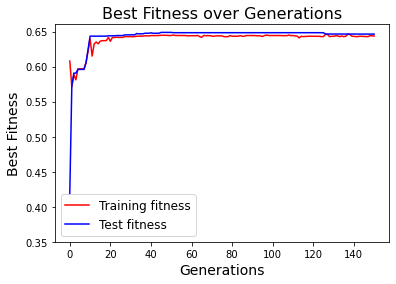

In [57]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.yticks(np.arange(0.35, 0.67, 0.05))
plt.show()

**Average fitness plot**

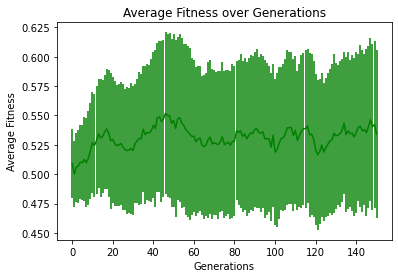

In [58]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

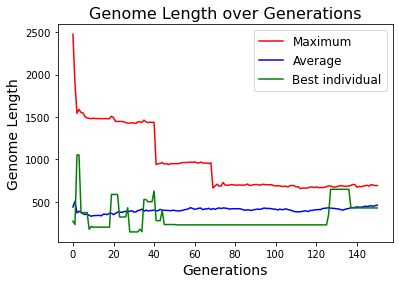

In [59]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()